In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost
# edited by Max (Jongyun Han)

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] == 'bool':
                continue
            else:
                raise 'unknown datatype'
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [8]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(train_symbol_ids_list))
train_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [9]:
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(test_symbol_ids_list))
test_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [10]:
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
print(len(unique_symbol_ids_list))
unique_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [11]:
train_df = read_parquet_files()
y_sr = train_df['responder_6']
train_df = train_df.drop('responder_6', axis=1)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]


Memory usage of dataframe is 14427.07 MB
Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [12]:
train_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47127338 entries, 0 to 47127337
Data columns (total 83 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   date_id     47127338 non-null  int16  
 1   time_id     47127338 non-null  int16  
 2   symbol_id   47127338 non-null  int8   
 3   weight      47127338 non-null  float16
 4   feature_00  43945286 non-null  float16
 5   feature_01  43945286 non-null  float16
 6   feature_02  43945286 non-null  float16
 7   feature_03  43945286 non-null  float16
 8   feature_04  43945286 non-null  float16
 9   feature_05  47127338 non-null  float16
 10  feature_06  47127338 non-null  float16
 11  feature_07  47127338 non-null  float16
 12  feature_08  46827091 non-null  float16
 13  feature_09  47127338 non-null  int8   
 14  feature_10  47127338 non-null  int8   
 15  feature_11  47127338 non-null  int16  
 16  feature_12  47127338 non-null  float16
 17  feature_13  47127338 non-null  float16
 18  

In [13]:
test_df = read_parquet_files(train_or_test='test')
test_row_id_sr = test_df['row_id']
test_df = test_df.drop(['row_id', 'is_scored'], axis=1)
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.06it/s]

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 26.0%
(39, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,0,0,5,2.605469,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,0,0,6,1.047852,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,0,0,7,4.230469,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,0,0,8,2.599609,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,

In [14]:
test_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 83 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_id     39 non-null     int8   
 1   time_id     39 non-null     int8   
 2   symbol_id   39 non-null     int8   
 3   weight      39 non-null     float16
 4   feature_00  39 non-null     float16
 5   feature_01  39 non-null     float16
 6   feature_02  39 non-null     float16
 7   feature_03  39 non-null     float16
 8   feature_04  39 non-null     float16
 9   feature_05  39 non-null     float16
 10  feature_06  39 non-null     float16
 11  feature_07  39 non-null     float16
 12  feature_08  39 non-null     float16
 13  feature_09  39 non-null     float16
 14  feature_10  39 non-null     float16
 15  feature_11  39 non-null     float16
 16  feature_12  39 non-null     float16
 17  feature_13  39 non-null     float16
 18  feature_14  39 non-null     float16
 19  feature_15  0 non-null      flo

In [15]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.15it/s]

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [16]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [17]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        df[new_col_name] = (df['symbol_id'] == v).astype(int)
    
    #df = df.drop('symbol_id', axis=1)

    return

In [18]:
one_hot_cat_cols(train_df)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 10.79it/s]

(47127338, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
one_hot_cat_cols(test_df)
print(test_df.shape)
test_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 3867.00it/s]

(39, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
sample_train_df = train_df.sample(frac=0.01)
print(sample_train_df.shape)
sample_train_df.head()

(471273, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
19264735,930,821,34,1.957031,-0.602051,0.676758,-1.167969,-0.972168,0.904297,1.149414,-0.204102,0.791016,-1.743164,42,5,150,-0.264648,-0.281982,-0.234131,-0.543457,-0.601562,-0.421631,1.824219,-1.391602,-0.809082,-0.145508,0.608887,0.083923,-0.531250,-0.915039,0.072632,1.481445,1.069336,-0.681641,-0.386230,-0.213745,0.322510,-0.011566,0.049103,0.390625,0.867676,-0.086609,-0.218750,-0.397217,-0.451660,0.112427,0.419922,-0.121887,0.353516,-0.540527,-0.388916,0.208862,-0.145874,-0.011284,-0.291504,-0.732422,-1.243164,1.085938,-0.384766,0.069702,0.091492,-0.213989,0.268066,-0.027985,-0.006489,-0.003454,-0.448730,-0.364014,-0.432373,1.576172,-0.115356,-0.269287,-0.199585,-0.244385,-0.128296,-0.504883,-0.300781,-0.290283,-0.332275,-0.299316,-0.260986,-0.247192,-0.305176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
20342817,965,91,38,1.756836,-0.089417,0.720703,0.324463,-0.108032,-0.580566,1.135742,0.031982,-0.304199,-0.695801,50,1,522,0.479492,0.107239,0.348877,-0.628418,-0.500488,-0.662109,-0.024490,-1.178711,0.325195,-0.223755,-0.035004,-0.484619,1.106445,-0.024216,-0.225830,0.946777,1.175781,-0.586914,-0.527832,-0.205688,1.092773,1.589844,1.389648,0.973145,0.804199,0.068481,0.120789,0.466553,-0.165039,-0.277344,-0.708984,-0.657715,-0.574219,-0.862305,0.445068,-0.071838,-0.710449,-0.671875,0.196655,-0.313965,-0.862793,-1.008789,0.577637,-1.313477,-1.048828,-0.203613,-0.213135,-0.765625,-0.670410,-1.475586,-0.518555,-0.343262,-0.497070,-0.583008,0.023254,0.187012,0.248901,0.351318,0.514648,-0.089844,0.214111,-0.197266,-0.150024,-0.272705,-0.247192,-0.186035,-0.231079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22774816,1037,565,8,3.658203,-0.994629,-0.874512,-1.022461,-0.777344,0.429932,-0.269287,0.681152,0.278564,0.280029,15,1,62,-0.697754,-0.379395,-0.622070,-0.223633,-0.197876,-0.199463,0.973633,0.193848,-0.850586,0.666016,1.330078,1.321289,0.385498,0.381104,0.341309,0.501465,-0.008110,-0.106445,-0.147461,0.623047,1.021484,0.334961,0.760254,0.150391,0.438232,-0.113159,-0.052673,-1.147461,0.075745,-0.043762,-0.042603,0.452637,1.015625,-0.687012,-0.324951,-0.185913,0.071472,-0.144775,-0.782227,-1.349609,-0.249390,0.708496,-0.380371,0.433105,-0.926758,-0.001289,-0.364014,0.030899,-0.292480,0.342529,-0.194458,-0.423584,-0.325684,0.515137,-0.092651,-0.631348,-0.373535,-0.619141,-0.791504,-0.377441,-0.834473,-0.378906,-0.298828,-0.297363,-0.241943,-0.370361,-0.412354,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4825726,344,467,12,1.769531,-1.300781,-0.699707,-1.09

In [21]:
sample_y_sr = y_sr.iloc[sample_train_df.index]
print(sample_y_sr.shape)
sample_y_sr.head()

(471273,)


19264735   -0.414795
20342817   -1.017578
22774816    1.294922
4825726    -0.847656
37915406   -1.138672
Name: responder_6, dtype: float16

In [30]:
feature_cols = [col for col in train_df.columns if 'feature' in col]
print(len(feature_cols))
feature_cols

79


['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_

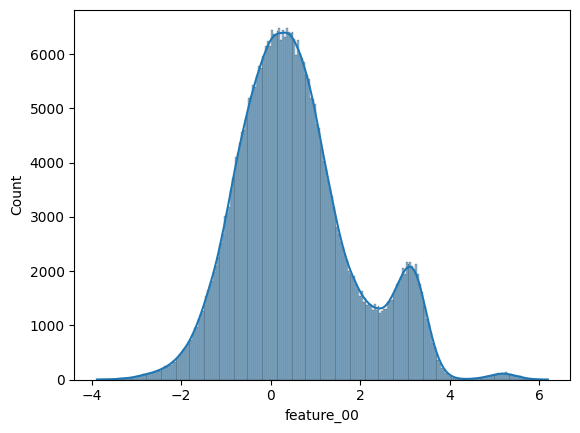

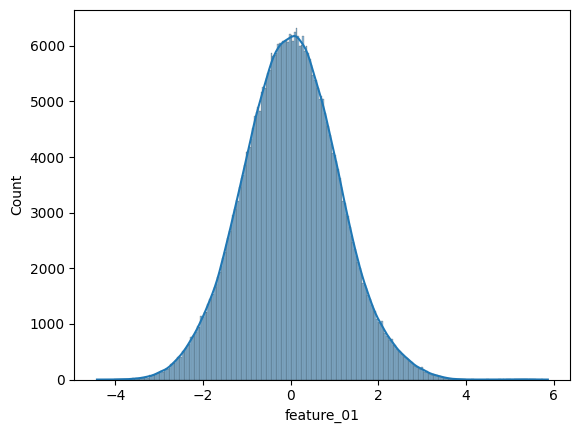

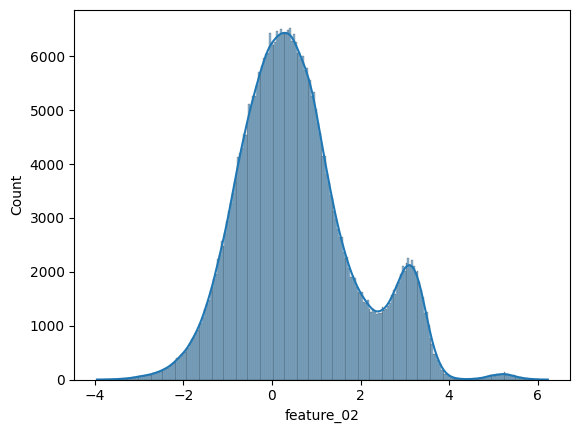

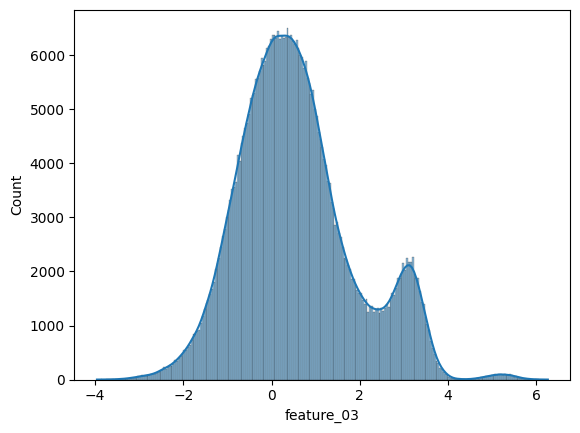

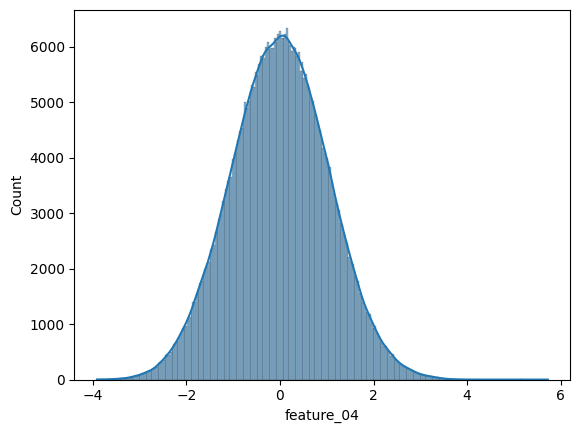

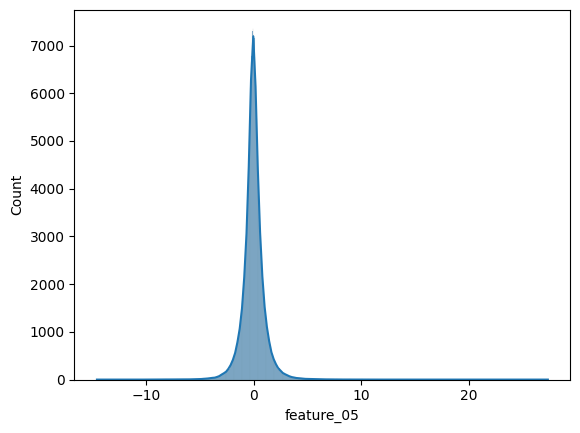

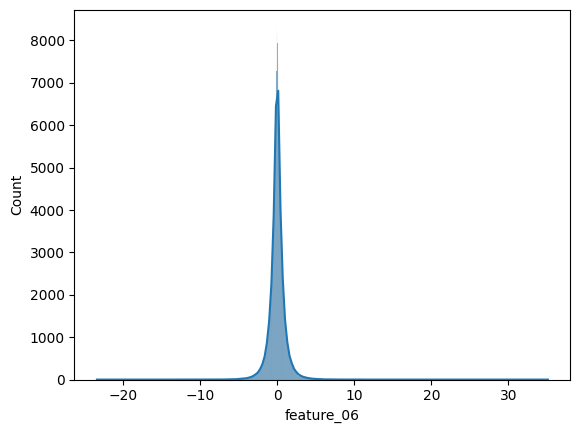

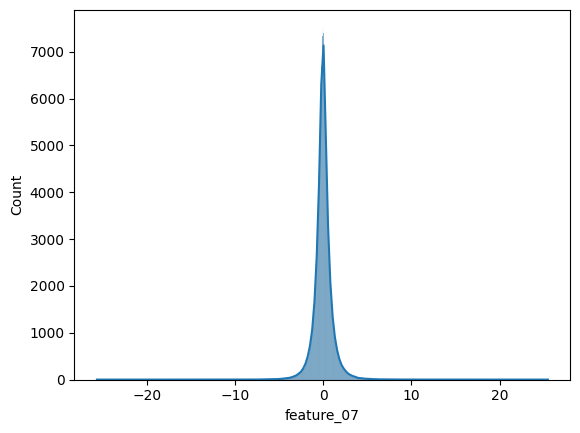

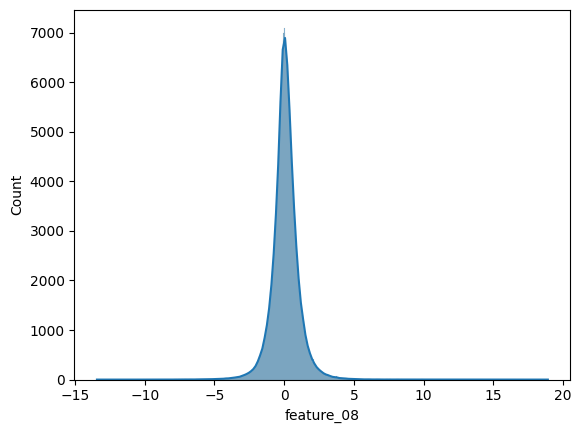

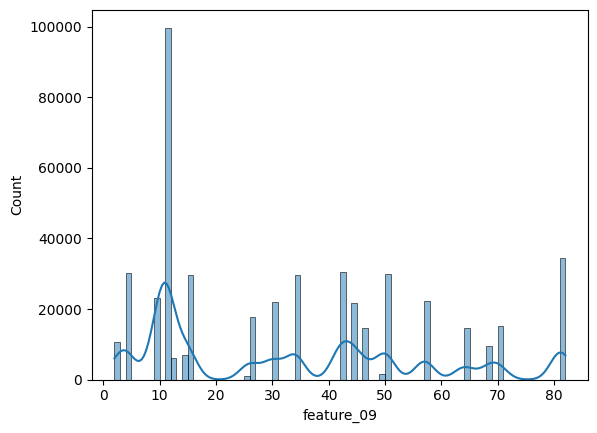

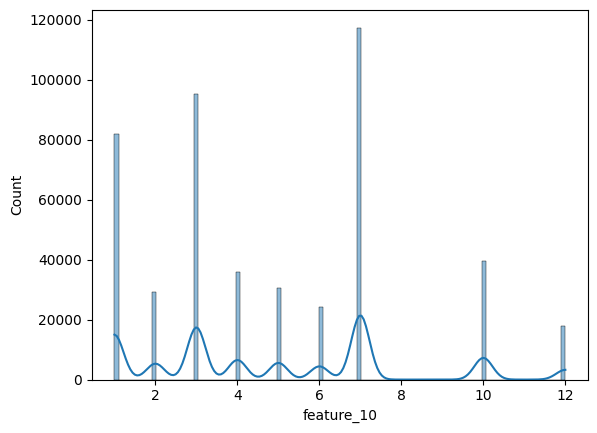

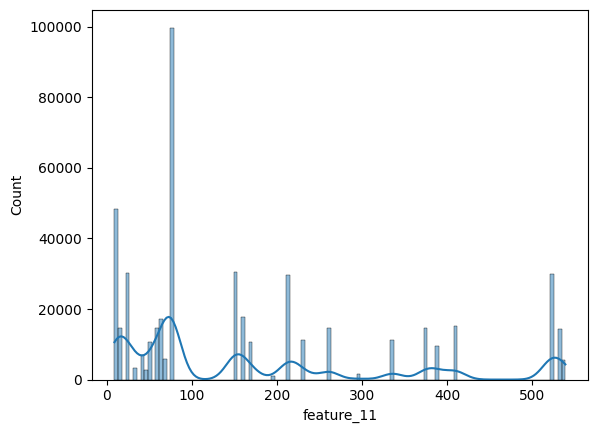

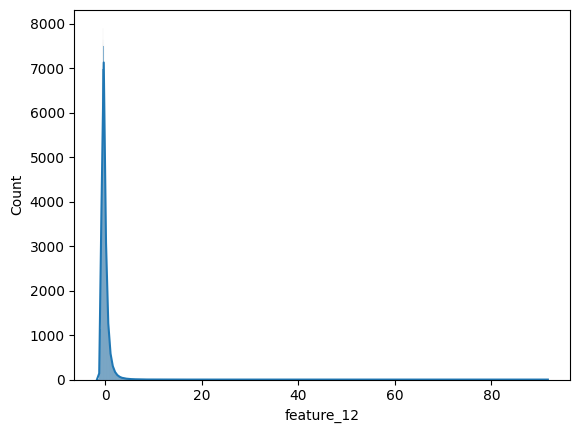

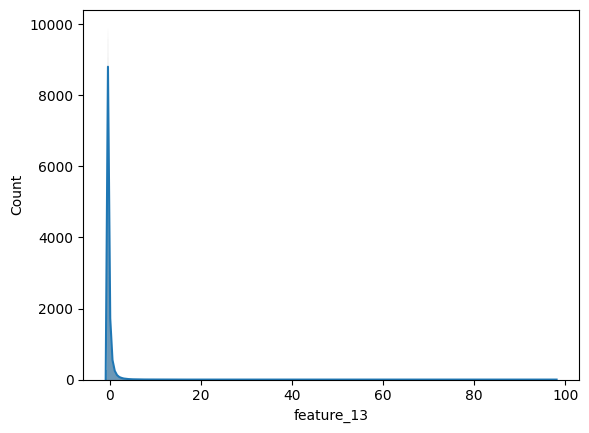

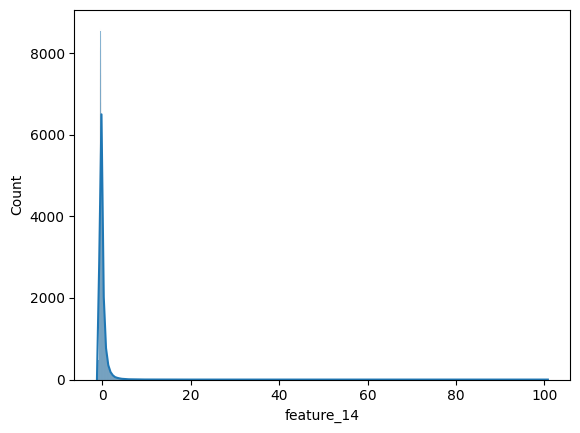

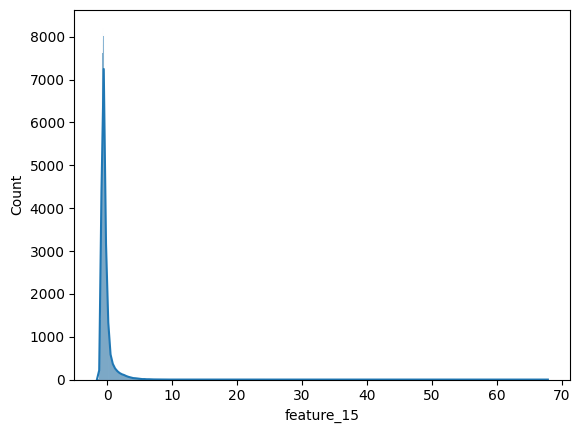

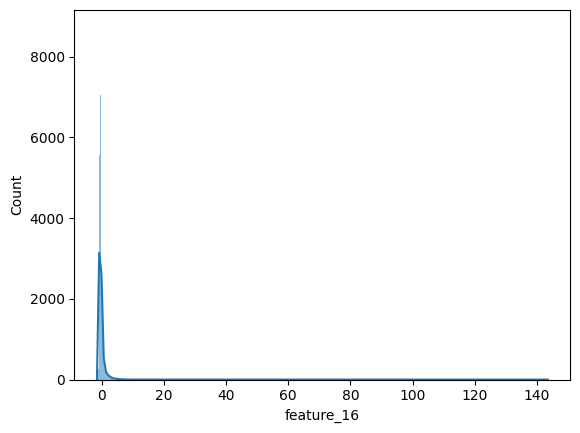

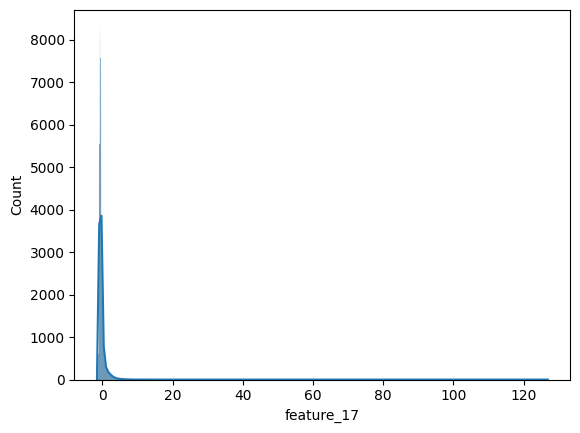

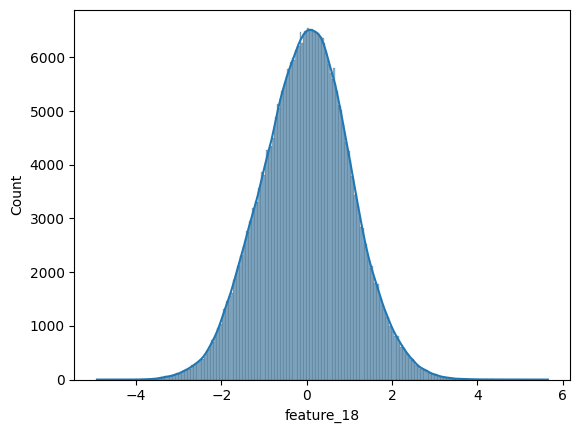

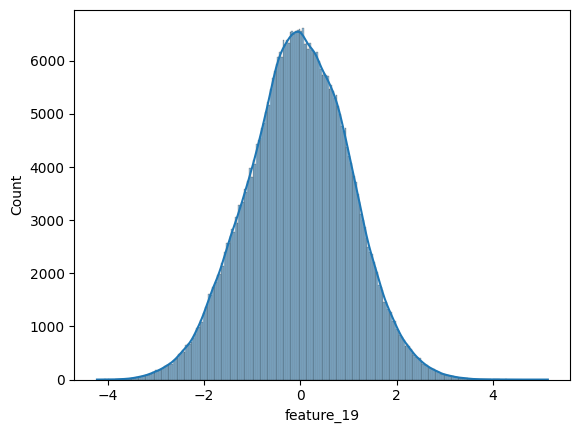

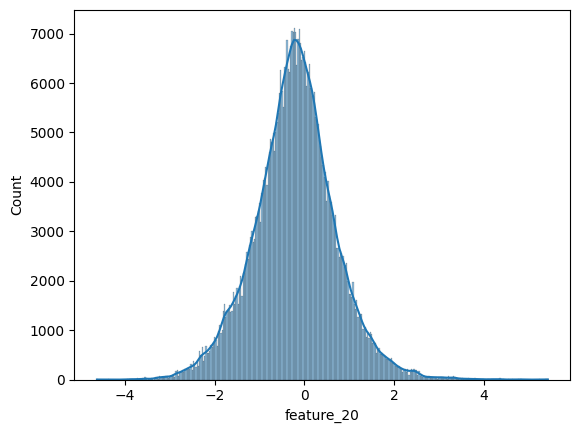

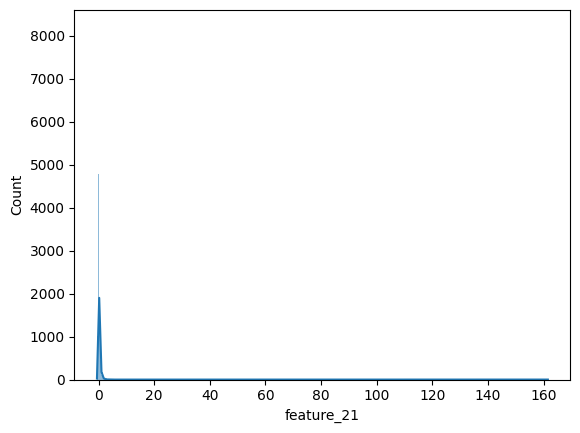

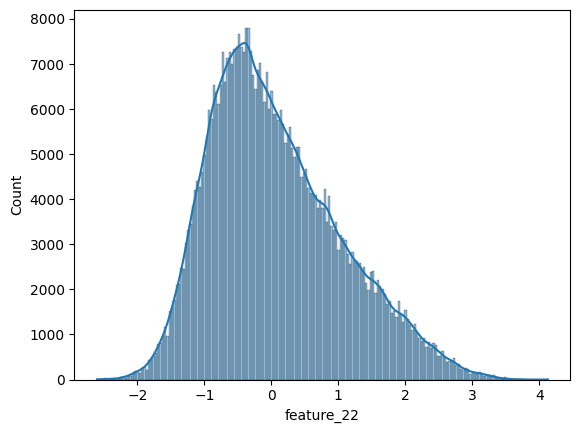

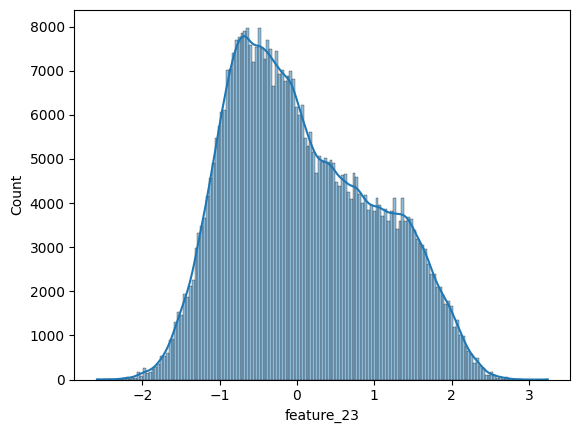

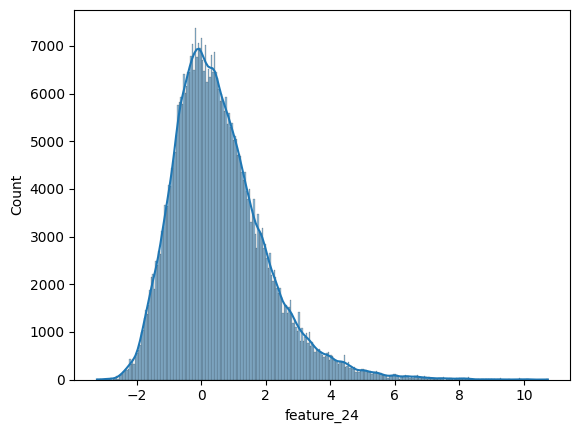

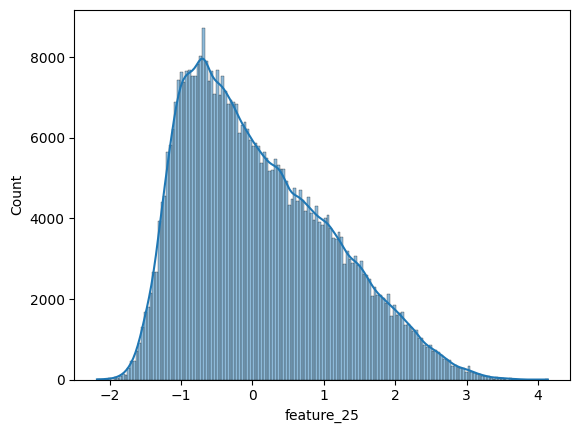

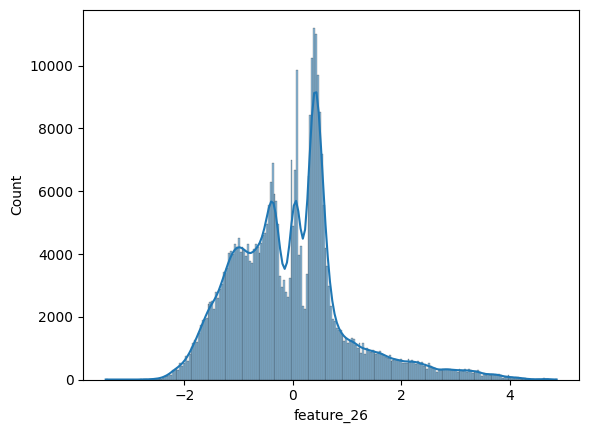

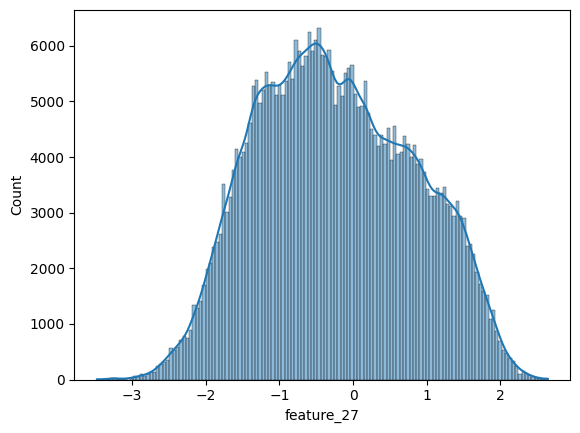

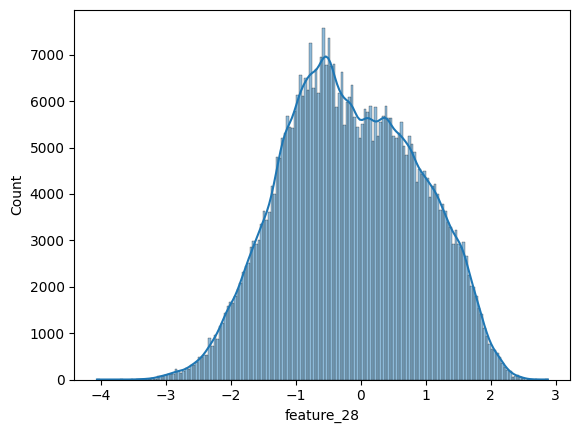

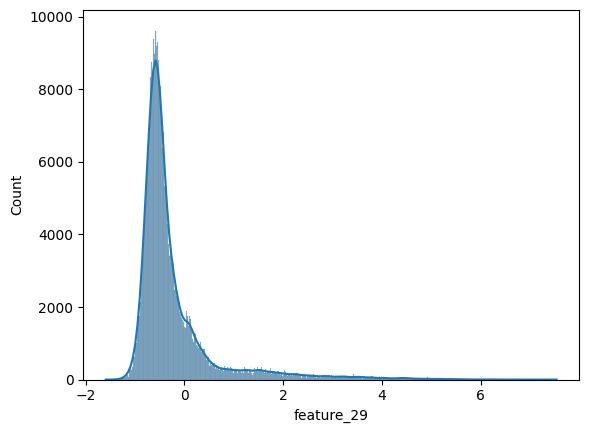

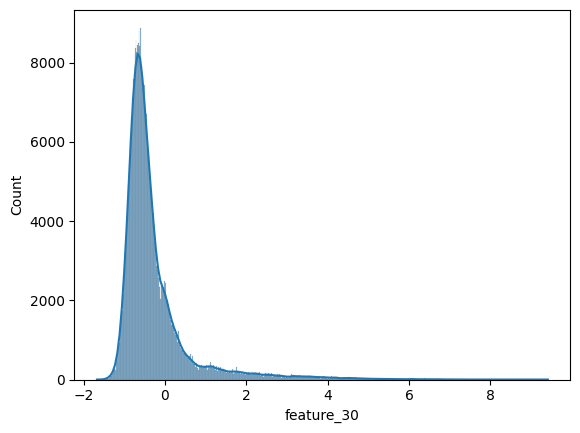

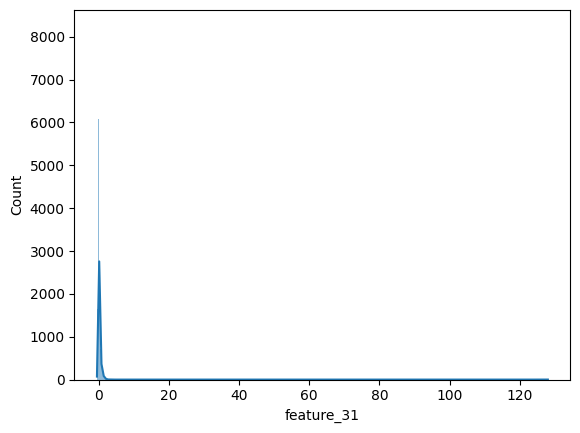

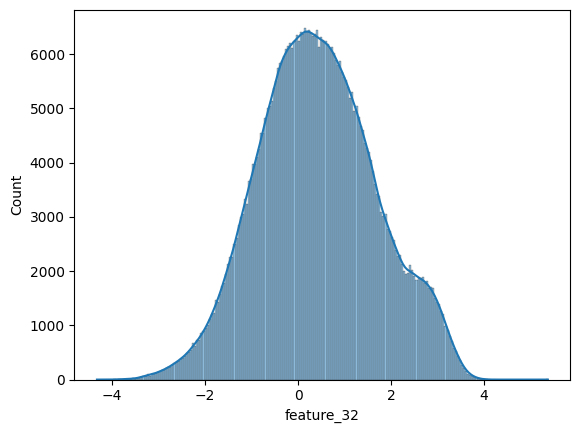

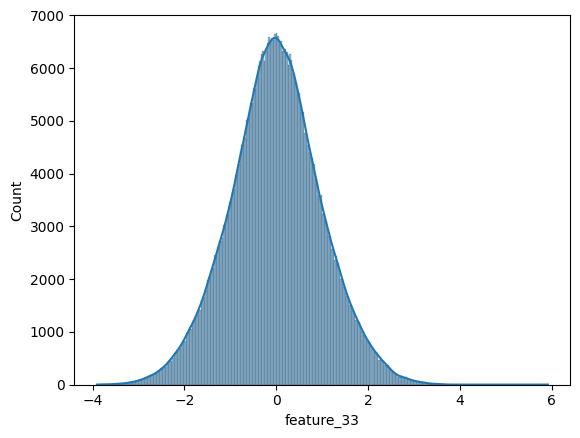

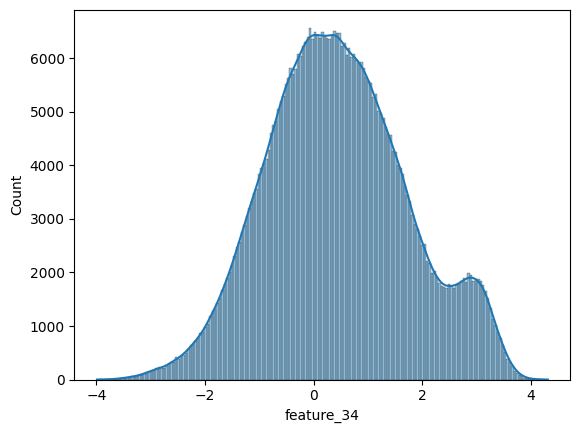

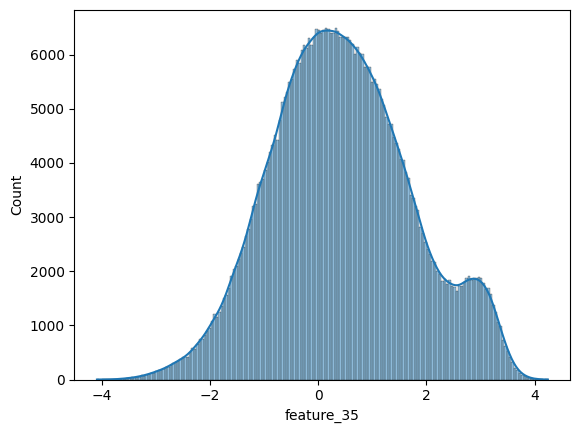

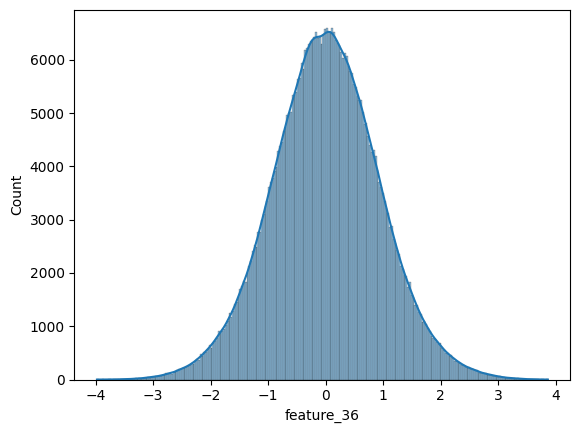

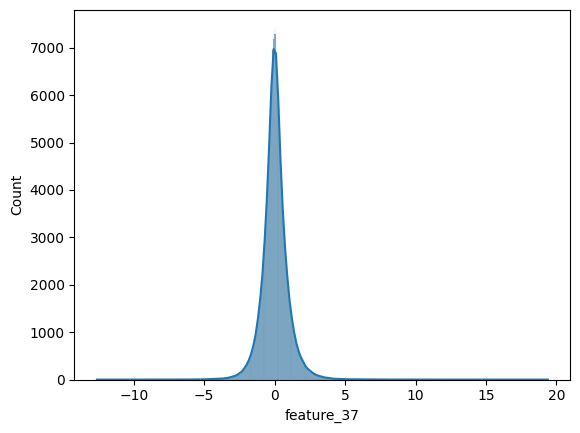

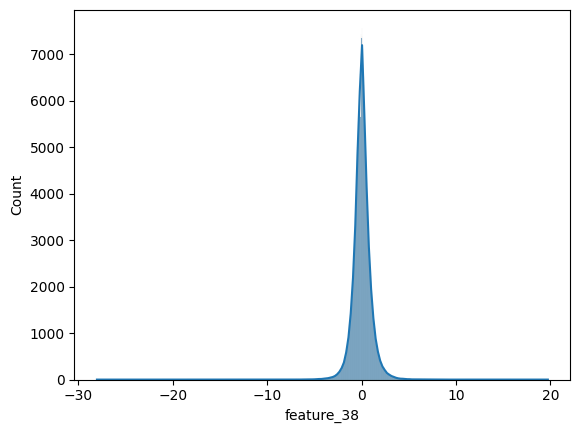

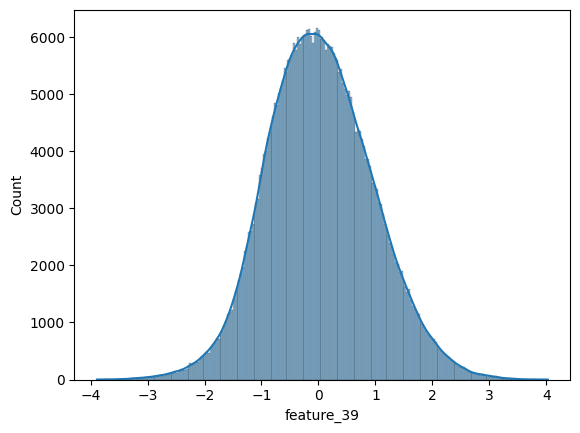

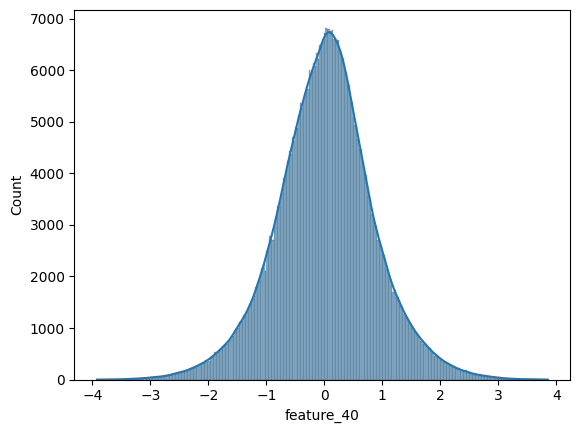

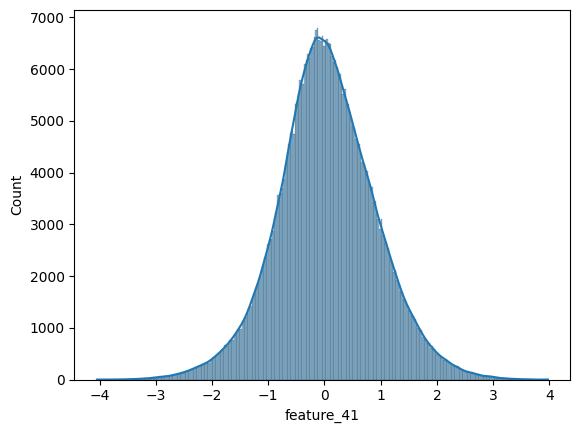

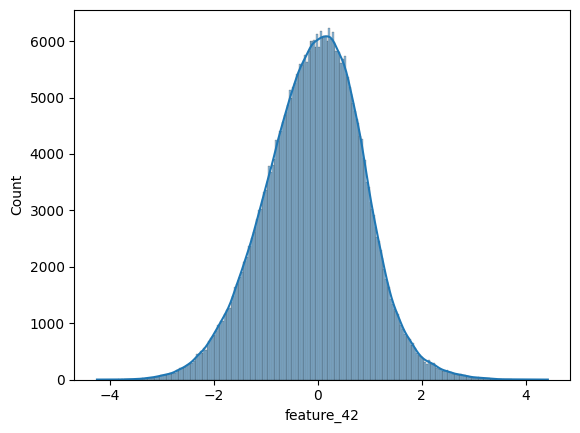

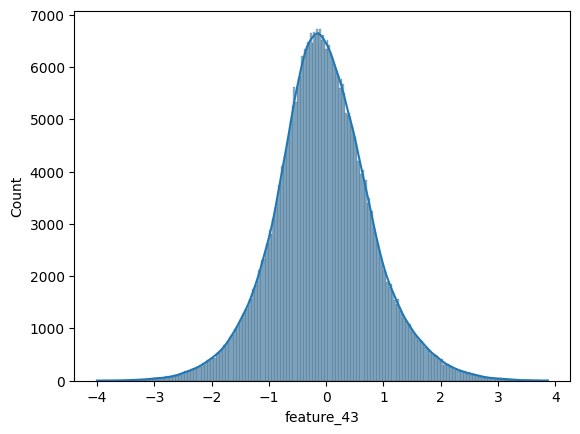

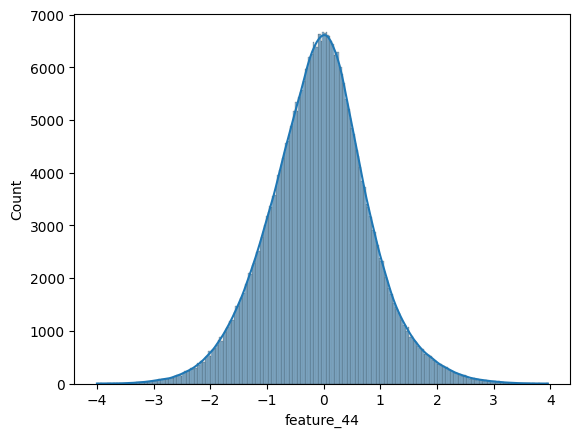

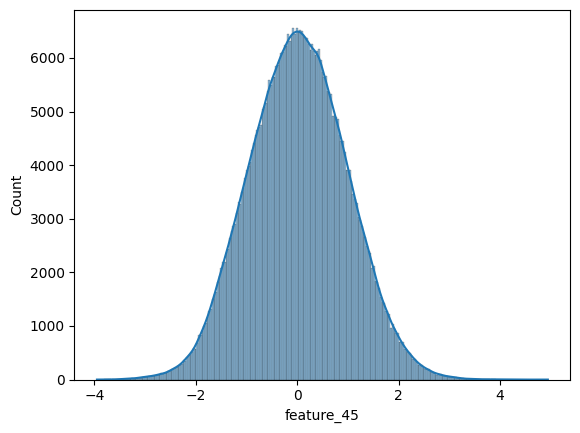

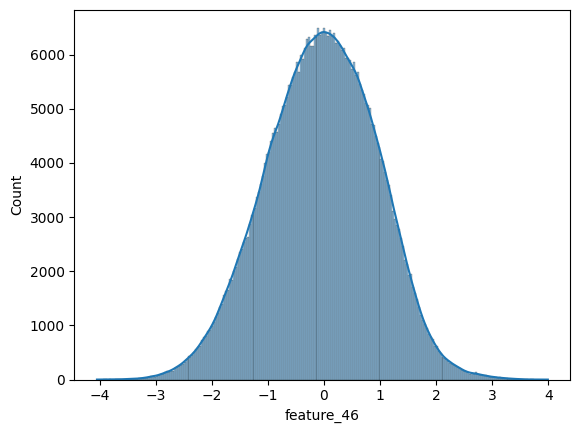

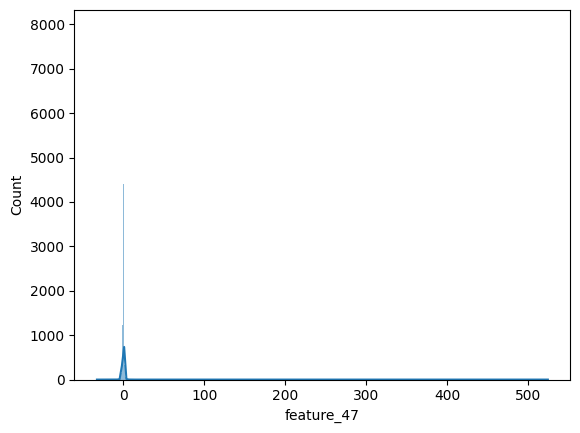

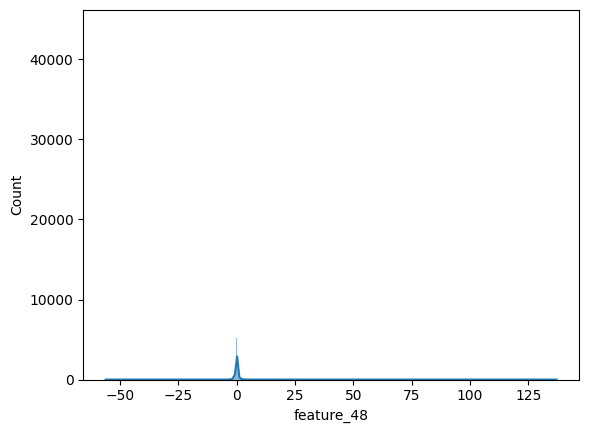

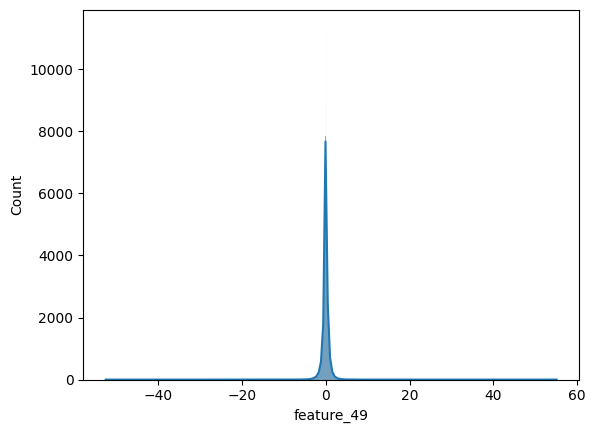

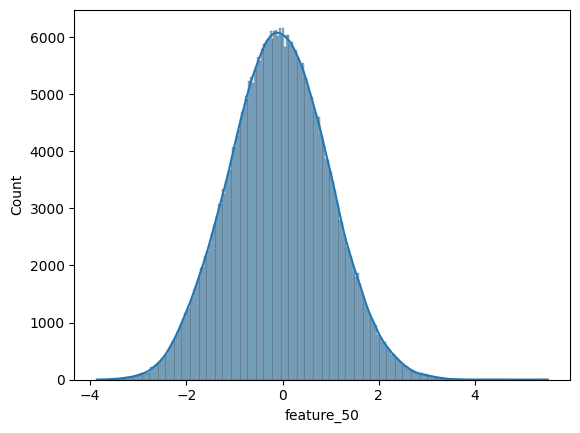

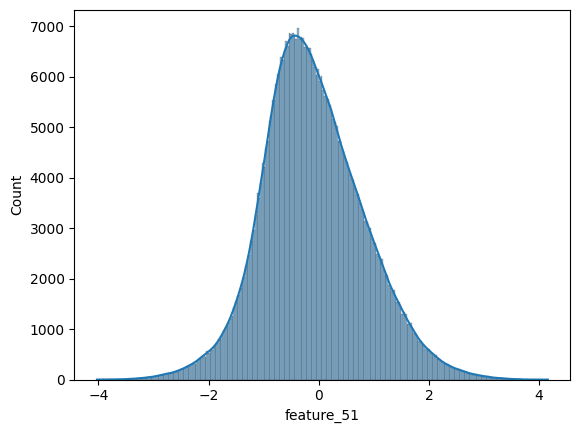

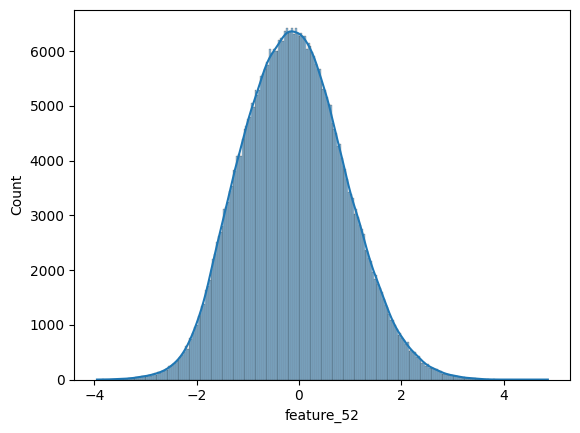

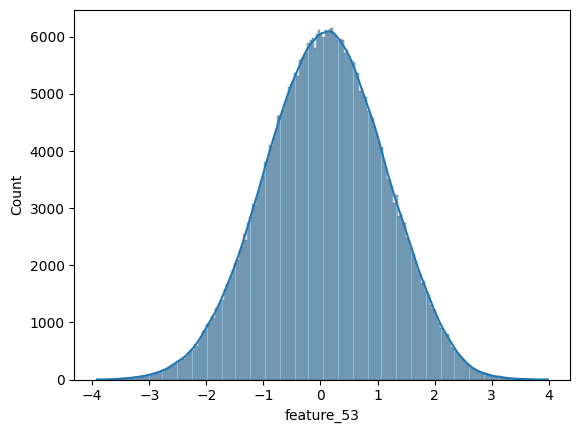

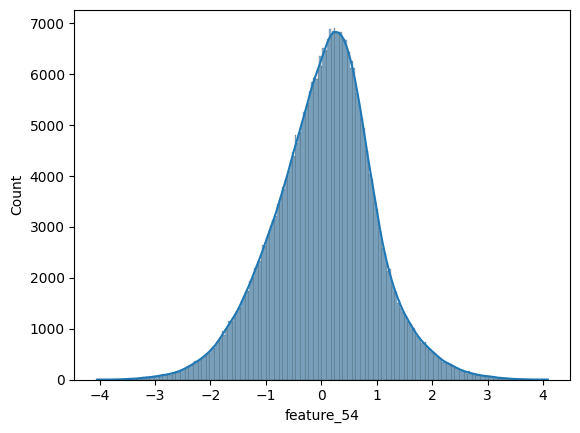

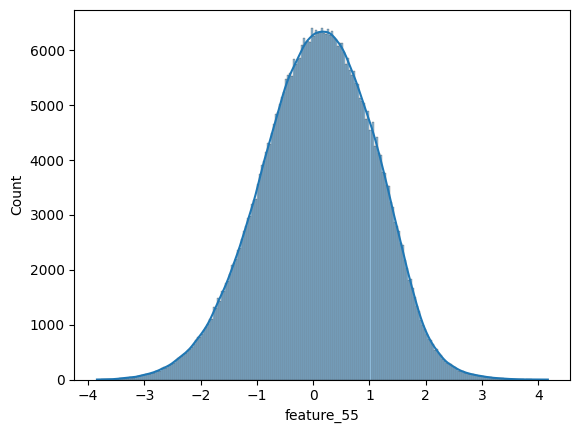

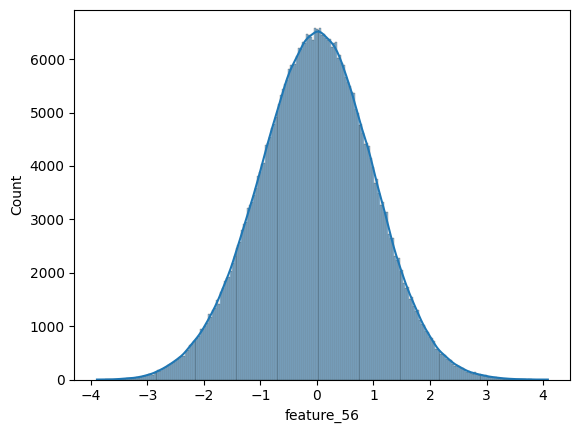

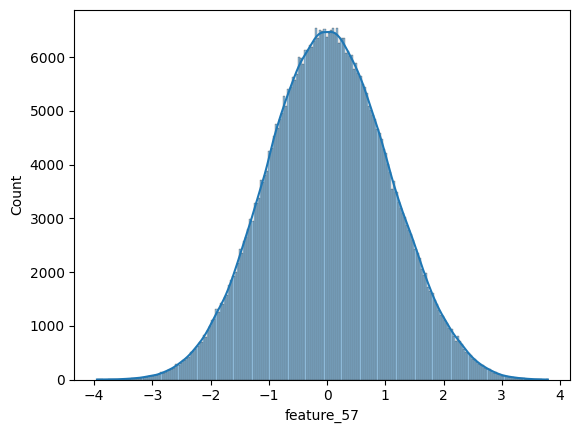

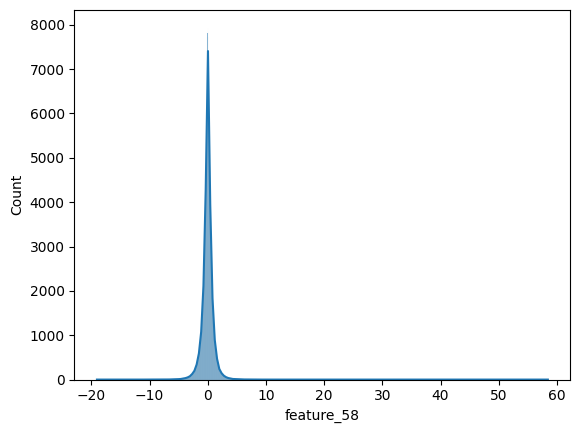

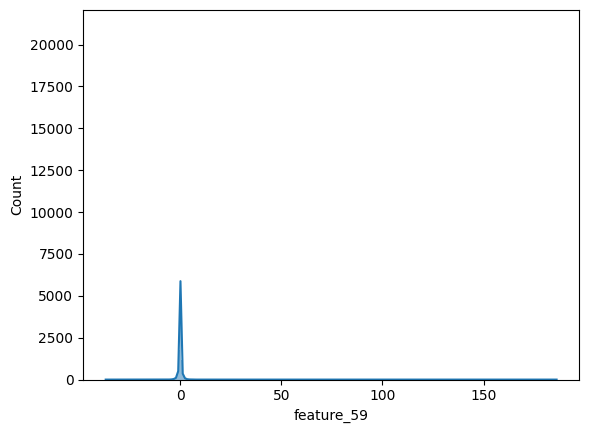

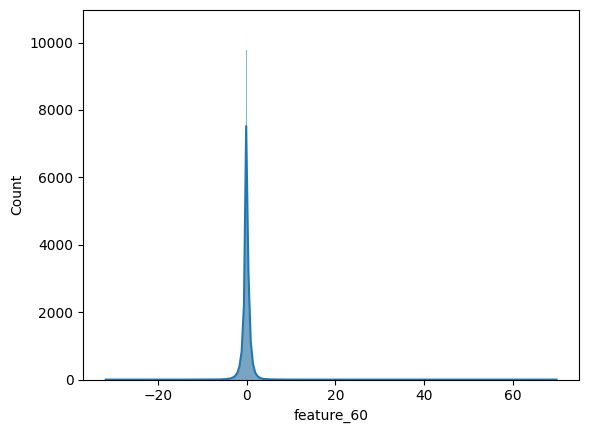

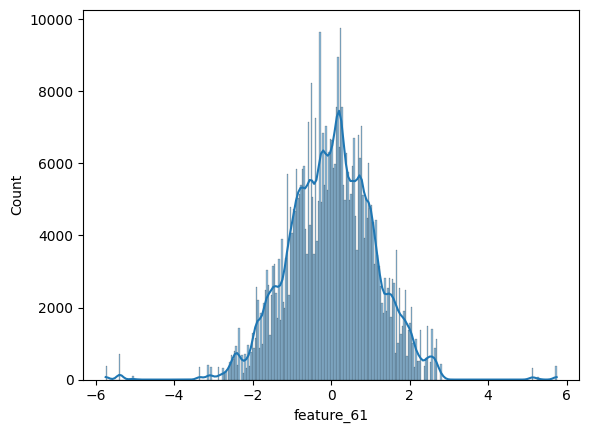

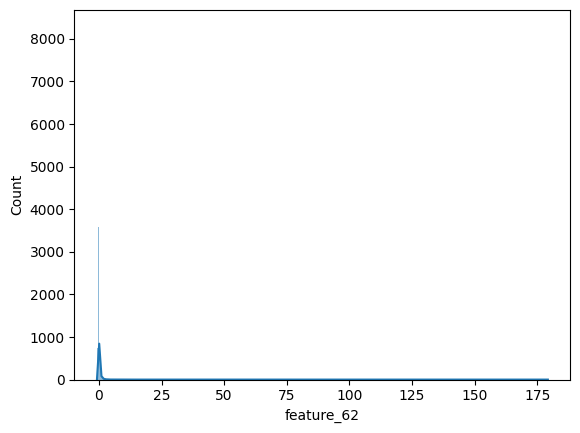

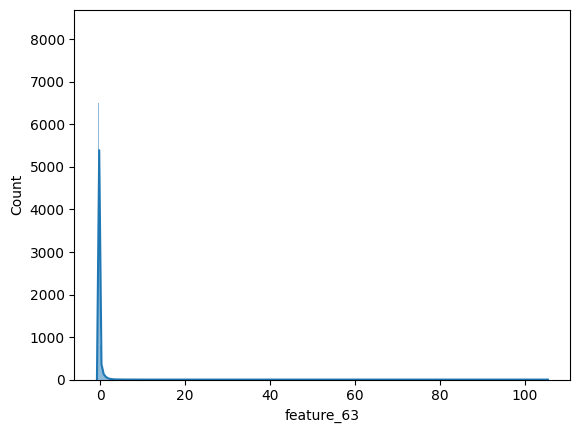

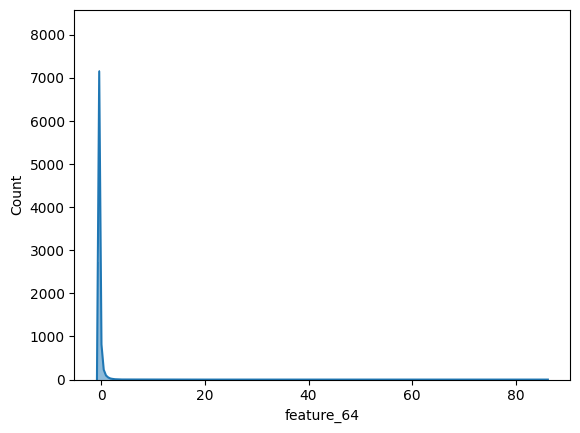

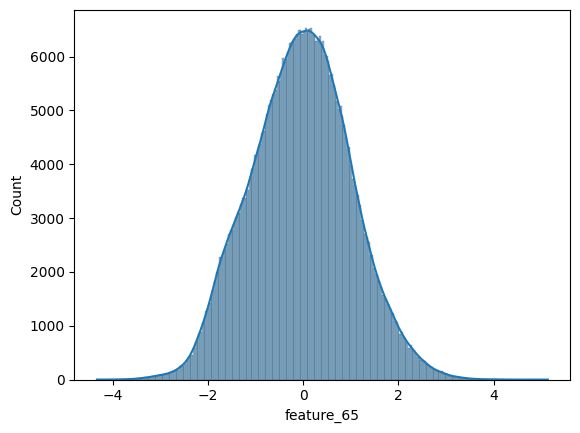

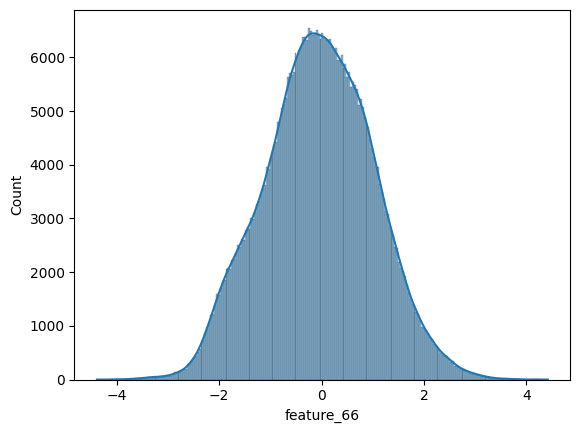

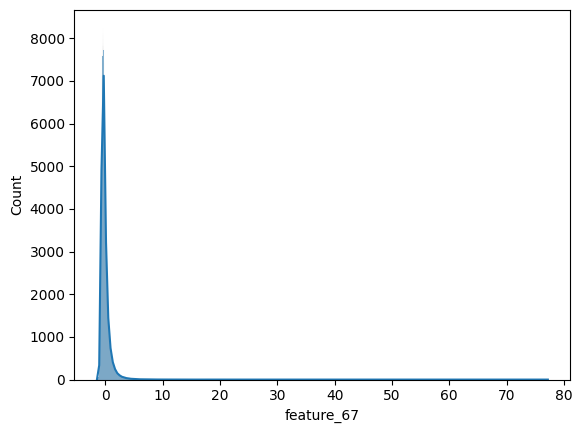

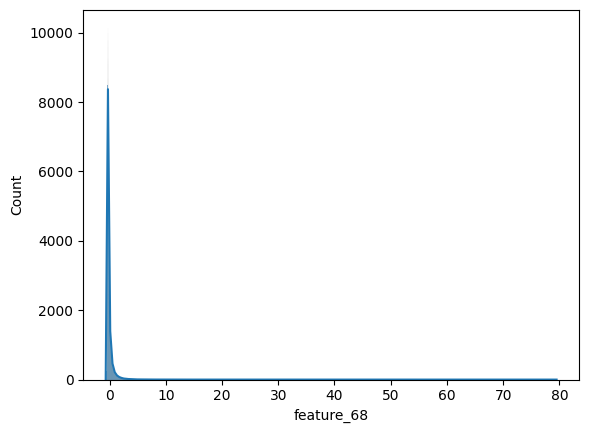

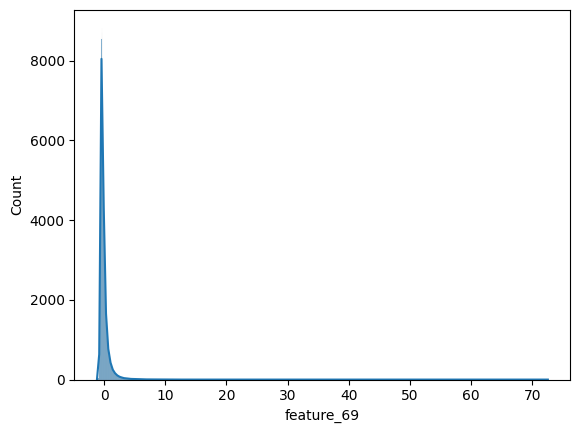

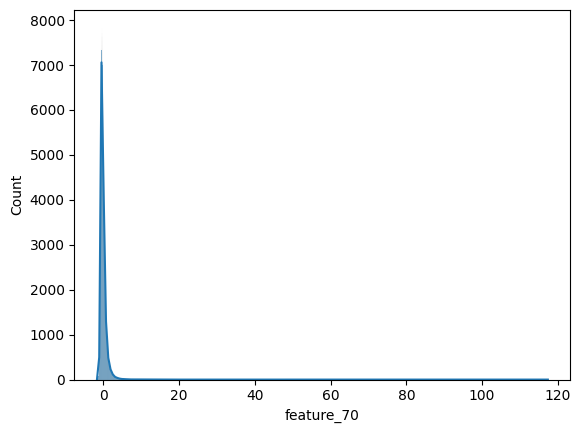

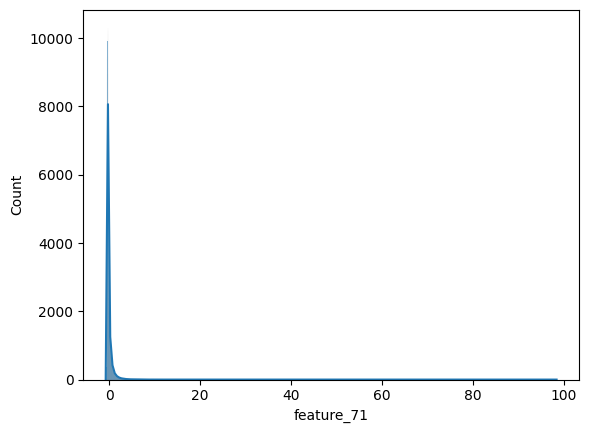

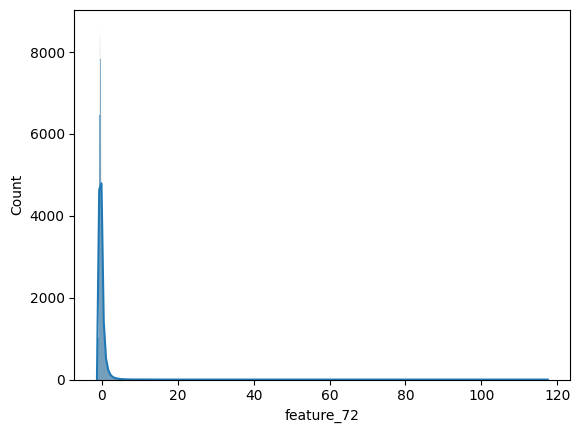

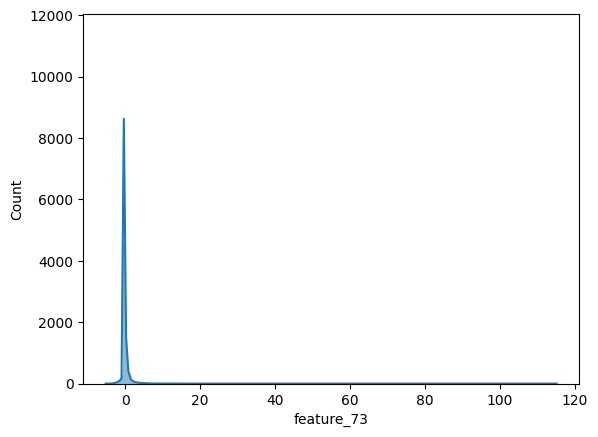

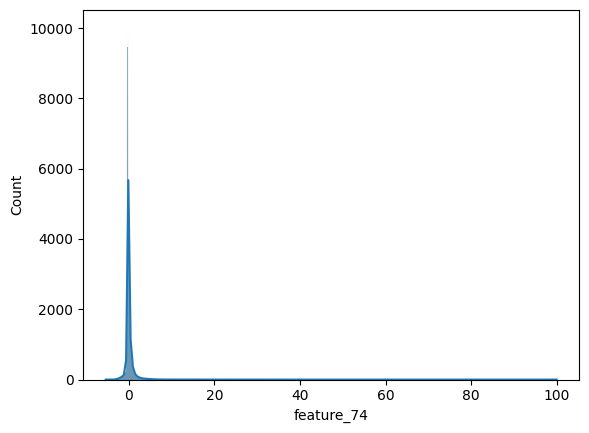

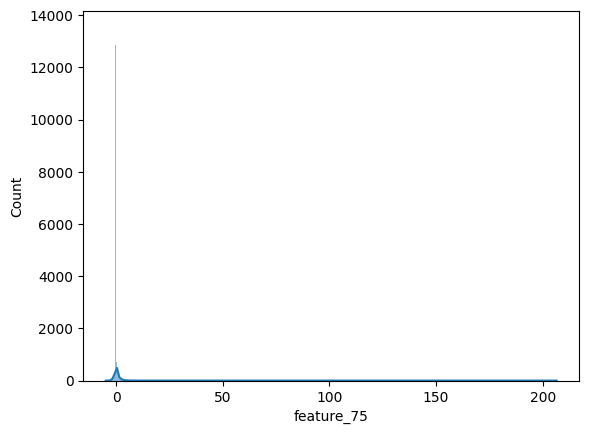

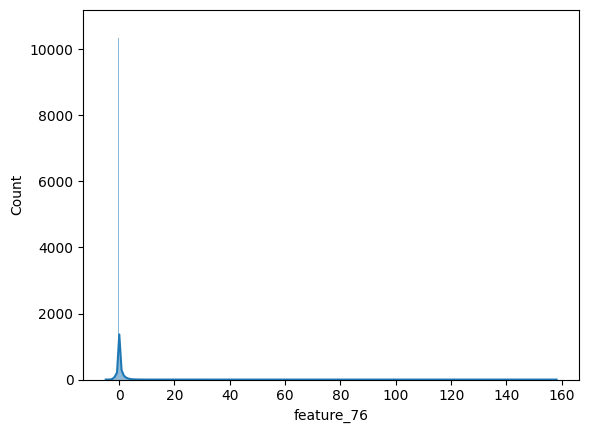

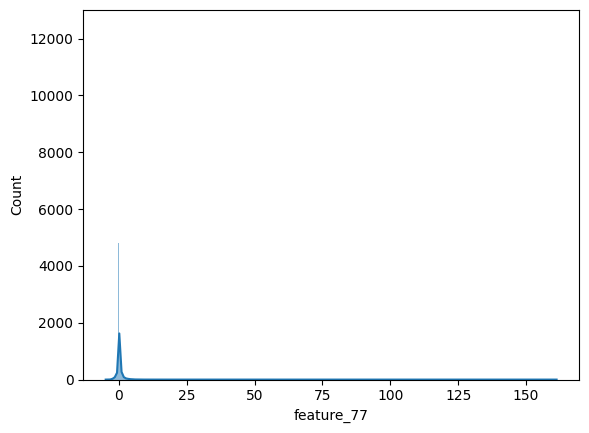

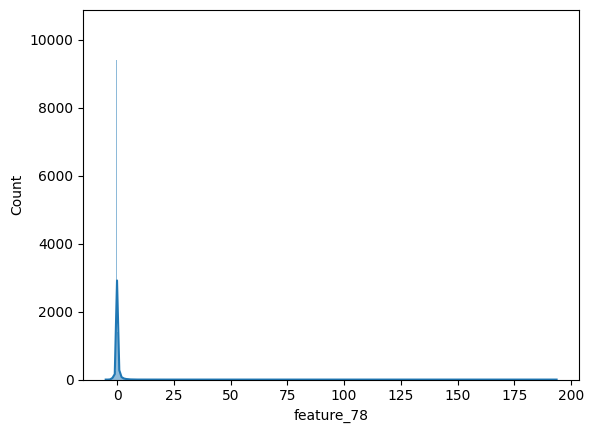

In [31]:
for feature in feature_cols:
    plt.figure()
    sns.histplot(x=sample_train_df[feature], kde=True)
    plt.show()

In [35]:
train_df['feature_09'].value_counts(normalize=True)

feature_09
11    0.211117
42    0.064740
4     0.063594
50    0.063363
34    0.063013
15    0.062816
81    0.061822
9     0.048907
57    0.047834
30    0.047050
44    0.046152
26    0.037899
70    0.032139
64    0.031271
46    0.030991
2     0.022435
68    0.020061
14    0.014994
12    0.012981
82    0.011646
49    0.003204
25    0.001972
Name: proportion, dtype: float64

In [33]:
train_df['feature_09'].nunique()

22

In [34]:
sorted(train_df['feature_09'].unique())

[2,
 4,
 9,
 11,
 12,
 14,
 15,
 25,
 26,
 30,
 34,
 42,
 44,
 46,
 49,
 50,
 57,
 64,
 68,
 70,
 81,
 82]

In [36]:
train_df['feature_10'].value_counts(normalize=True)

feature_10
7     0.248432
3     0.201290
1     0.174012
10    0.084479
4     0.075994
5     0.064740
2     0.061822
6     0.051332
12    0.037899
Name: proportion, dtype: float64

In [37]:
train_df['feature_10'].nunique()

9

In [38]:
sorted(train_df['feature_10'].unique())

[1, 2, 3, 4, 5, 6, 7, 10, 12]

In [39]:
train_df['feature_11'].value_counts(normalize=True)

feature_11
76     0.211117
150    0.064740
11     0.063594
522    0.063363
214    0.063013
25     0.048907
158    0.037233
410    0.032139
59     0.031498
376    0.031271
261    0.030991
16     0.030952
534    0.030324
62     0.029808
13     0.024222
336    0.023935
230    0.023899
50     0.022827
171    0.022435
388    0.020061
24     0.015200
40     0.014994
9      0.014501
66     0.011872
539    0.011646
34     0.007168
63     0.006634
48     0.005813
297    0.003204
195    0.001972
159    0.000667
Name: proportion, dtype: float64

In [40]:
train_df['feature_11'].nunique()

31

In [41]:
sorted(train_df['feature_11'].unique())

[9,
 11,
 13,
 16,
 24,
 25,
 34,
 40,
 48,
 50,
 59,
 62,
 63,
 66,
 76,
 150,
 158,
 159,
 171,
 195,
 214,
 230,
 261,
 297,
 336,
 376,
 388,
 410,
 522,
 534,
 539]

In [43]:
corr_df = train_df[feature_cols].corr()

In [48]:
# Find features with high correlation
high_corr = np.where(corr_df >= 0.95)
high_corr_pairs = [
    (corr_df.index[x], corr_df.columns[y])
    for x, y in zip(*high_corr)
    if x != y and x < y
]

In [49]:
second_v_list = []
for v in high_corr_pairs:
    second_v = v[1]
    second_v_list.append(second_v)

In [50]:
redundant_features = list(set(second_v_list))

In [51]:
redundant_features

['feature_78', 'feature_74', 'feature_76', 'feature_31']

In [22]:
n_splits = 5

In [29]:
def lgb_train(train_data, y):
    #X = train_data.drop(['weight', 'responder_6', 'row_id', 'is_scored'], axis=1)
    X = train_data.drop(['date_id', 'time_id', 'symbol_id'], axis=1)
    #y = train_data['responder_6']
    weights = train_data['weight']
    print(X.shape)
    display(X.head())
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.003,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 50,
    }

    cv_fold = KFold(n_splits=n_splits, shuffle=True)#, shuffle=True, random_state=6)

    for fold, (train_idx, test_idx) in enumerate(cv_fold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        #weights_train, weights_val = weights.iloc[train_idx], weights.iloc[test_idx]

        model = LGBMRegressor(
            **base_params,
            n_estimators=100000
        )

        #model.fit(train_dmatrix, eval_set=val_dmatrix, verbose=10)
        
        #model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight_eval_set=[weights_train, weights_val], verbose=50)
        #model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], callbacks=[log_evaluation(period=50)])
        
        oof[test_idx] = model.predict(X_val)

        plt.figure()
        lgb.plot_metric(model)
        plt.ylim(0, 1)
        plt.show()

        '''plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        train_rmse = eval_results['validation_0']['rmse']
        val_rmse = eval_results['validation_1']['rmse']
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.ylabel('RMSE')
        plt.title('Training vs Validation RMSE')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()'''

        #print(model.score(X_val, y_val, sample_weight=weights_val))

        models_path = path + 'my_folder/models/20241224_02/'

        if not os.path.exists(models_path):
            os.makedirs(models_path)

        with open(models_path + f"lgb_model_{fold}.pkl", 'wb') as file:
            pickle.dump(model, file)

    print('R2 score is:', r2_score(y, oof))#, sample_weight=weights))
    print('Weighted R2 score is:', r2_score(y, oof, sample_weight=weights))

    return

(471273, 119)


,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
19264735,1.957031,-0.602051,0.676758,-1.167969,-0.972168,0.904297,1.149414,-0.204102,0.791016,-1.743164,42,5,150,-0.264648,-0.281982,-0.234131,-0.543457,-0.601562,-0.421631,1.824219,-1.391602,-0.809082,-0.145508,0.608887,0.083923,-0.531250,-0.915039,0.072632,1.481445,1.069336,-0.681641,-0.386230,-0.213745,0.322510,-0.011566,0.049103,0.390625,0.867676,-0.086609,-0.218750,-0.397217,-0.451660,0.112427,0.419922,-0.121887,0.353516,-0.540527,-0.388916,0.208862,-0.145874,-0.011284,-0.291504,-0.732422,-1.243164,1.085938,-0.384766,0.069702,0.091492,-0.213989,0.268066,-0.027985,-0.006489,-0.003454,-0.448730,-0.364014,-0.432373,1.576172,-0.115356,-0.269287,-0.199585,-0.244385,-0.128296,-0.504883,-0.300781,-0.290283,-0.332275,-0.299316,-0.260986,-0.247192,-0.305176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
20342817,1.756836,-0.089417,0.720703,0.324463,-0.108032,-0.580566,1.135742,0.031982,-0.304199,-0.695801,50,1,522,0.479492,0.107239,0.348877,-0.628418,-0.500488,-0.662109,-0.024490,-1.178711,0.325195,-0.223755,-0.035004,-0.484619,1.106445,-0.024216,-0.225830,0.946777,1.175781,-0.586914,-0.527832,-0.205688,1.092773,1.589844,1.389648,0.973145,0.804199,0.068481,0.120789,0.466553,-0.165039,-0.277344,-0.708984,-0.657715,-0.574219,-0.862305,0.445068,-0.071838,-0.710449,-0.671875,0.196655,-0.313965,-0.862793,-1.008789,0.577637,-1.313477,-1.048828,-0.203613,-0.213135,-0.765625,-0.670410,-1.475586,-0.518555,-0.343262,-0.497070,-0.583008,0.023254,0.187012,0.248901,0.351318,0.514648,-0.089844,0.214111,-0.197266,-0.150024,-0.272705,-0.247192,-0.186035,-0.231079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22774816,3.658203,-0.994629,-0.874512,-1.022461,-0.777344,0.429932,-0.269287,0.681152,0.278564,0.280029,15,1,62,-0.697754,-0.379395,-0.622070,-0.223633,-0.197876,-0.199463,0.973633,0.193848,-0.850586,0.666016,1.330078,1.321289,0.385498,0.381104,0.341309,0.501465,-0.008110,-0.106445,-0.147461,0.623047,1.021484,0.334961,0.760254,0.150391,0.438232,-0.113159,-0.052673,-1.147461,0.075745,-0.043762,-0.042603,0.452637,1.015625,-0.687012,-0.324951,-0.185913,0.071472,-0.144775,-0.782227,-1.349609,-0.249390,0.708496,-0.380371,0.433105,-0.926758,-0.001289,-0.364014,0.030899,-0.292480,0.342529,-0.194458,-0.423584,-0.325684,0.515137,-0.092651,-0.631348,-0.373535,-0.619141,-0.791504,-0.377441,-0.834473,-0.378906,-0.298828,-0.297363,-0.241943,-0.370361,-0.412354,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4825726,1.769531,-1.300781,-0.699707,-1.091797,-1.207031,0.868164,2.453125,2.703125,2.638672,0.975098,70,7,410,

[50]	training's l2: 0.792295	valid_1's l2: 0.798065
[100]	training's l2: 0.790697	valid_1's l2: 0.797267
[150]	training's l2: 0.789251	valid_1's l2: 0.796579
[200]	training's l2: 0.787933	valid_1's l2: 0.795928
[250]	training's l2: 0.786688	valid_1's l2: 0.795414
[300]	training's l2: 0.785537	valid_1's l2: 0.794996
[350]	training's l2: 0.784416	valid_1's l2: 0.794569
[400]	training's l2: 0.783344	valid_1's l2: 0.794242
[450]	training's l2: 0.782321	valid_1's l2: 0.793932
[500]	training's l2: 0.781341	valid_1's l2: 0.793663
[550]	training's l2: 0.780353	valid_1's l2: 0.793424
[600]	training's l2: 0.779399	valid_1's l2: 0.793235
[650]	training's l2: 0.778483	valid_1's l2: 0.793085
[700]	training's l2: 0.777585	valid_1's l2: 0.792891
[750]	training's l2: 0.776697	valid_1's l2: 0.79275
[800]	training's l2: 0.77583	valid_1's l2: 0.792618
[850]	training's l2: 0.774974	valid_1's l2: 0.792498
[900]	training's l2: 0.774137	valid_1's l2: 0.792359
[950]	training's l2: 0.773317	valid_1's l2: 0.792

<Figure size 640x480 with 0 Axes>

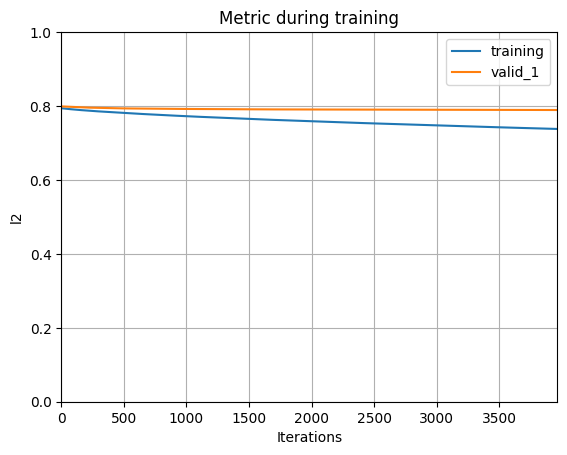

[50]	training's l2: 0.792745	valid_1's l2: 0.796438
[100]	training's l2: 0.791152	valid_1's l2: 0.795608
[150]	training's l2: 0.789668	valid_1's l2: 0.794954
[200]	training's l2: 0.788312	valid_1's l2: 0.794361
[250]	training's l2: 0.787056	valid_1's l2: 0.793825
[300]	training's l2: 0.785888	valid_1's l2: 0.793326
[350]	training's l2: 0.78479	valid_1's l2: 0.792916
[400]	training's l2: 0.783747	valid_1's l2: 0.792553
[450]	training's l2: 0.782722	valid_1's l2: 0.792213
[500]	training's l2: 0.781743	valid_1's l2: 0.791946
[550]	training's l2: 0.780774	valid_1's l2: 0.791682
[600]	training's l2: 0.779835	valid_1's l2: 0.791428
[650]	training's l2: 0.778893	valid_1's l2: 0.79126
[700]	training's l2: 0.777974	valid_1's l2: 0.791067
[750]	training's l2: 0.777108	valid_1's l2: 0.79093
[800]	training's l2: 0.776255	valid_1's l2: 0.790798
[850]	training's l2: 0.775419	valid_1's l2: 0.790618
[900]	training's l2: 0.774606	valid_1's l2: 0.790452
[950]	training's l2: 0.773812	valid_1's l2: 0.7903

<Figure size 640x480 with 0 Axes>

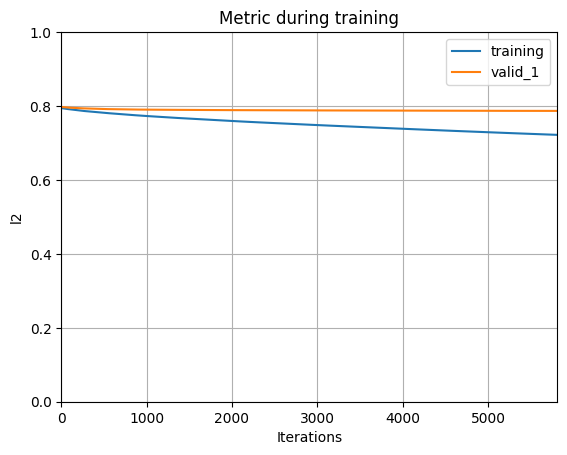

[50]	training's l2: 0.791484	valid_1's l2: 0.80116
[100]	training's l2: 0.789872	valid_1's l2: 0.800369
[150]	training's l2: 0.788375	valid_1's l2: 0.799718
[200]	training's l2: 0.787	valid_1's l2: 0.799155
[250]	training's l2: 0.785719	valid_1's l2: 0.798649
[300]	training's l2: 0.784533	valid_1's l2: 0.798216
[350]	training's l2: 0.78341	valid_1's l2: 0.7978
[400]	training's l2: 0.782344	valid_1's l2: 0.797452
[450]	training's l2: 0.781314	valid_1's l2: 0.797161
[500]	training's l2: 0.780308	valid_1's l2: 0.79692
[550]	training's l2: 0.779322	valid_1's l2: 0.796707
[600]	training's l2: 0.778372	valid_1's l2: 0.79651
[650]	training's l2: 0.777453	valid_1's l2: 0.796338
[700]	training's l2: 0.776534	valid_1's l2: 0.79619
[750]	training's l2: 0.775636	valid_1's l2: 0.79607
[800]	training's l2: 0.774784	valid_1's l2: 0.795924
[850]	training's l2: 0.773944	valid_1's l2: 0.795812
[900]	training's l2: 0.773124	valid_1's l2: 0.795697
[950]	training's l2: 0.772322	valid_1's l2: 0.795545
[1000

<Figure size 640x480 with 0 Axes>

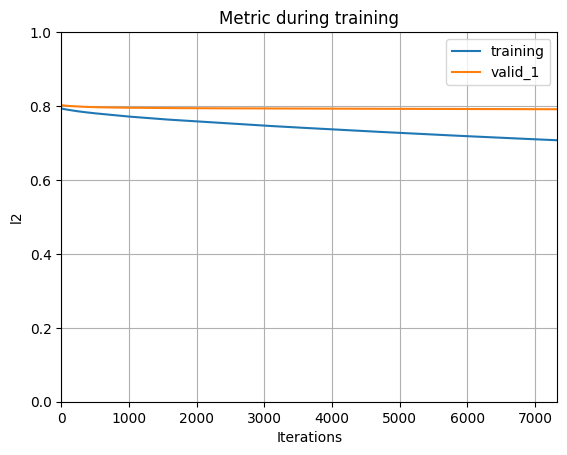

[50]	training's l2: 0.796932	valid_1's l2: 0.779453
[100]	training's l2: 0.795246	valid_1's l2: 0.778732
[150]	training's l2: 0.793724	valid_1's l2: 0.77812
[200]	training's l2: 0.792349	valid_1's l2: 0.777601
[250]	training's l2: 0.791056	valid_1's l2: 0.777202
[300]	training's l2: 0.789854	valid_1's l2: 0.776814
[350]	training's l2: 0.788714	valid_1's l2: 0.776471
[400]	training's l2: 0.787645	valid_1's l2: 0.776164
[450]	training's l2: 0.78663	valid_1's l2: 0.775938
[500]	training's l2: 0.785631	valid_1's l2: 0.775752
[550]	training's l2: 0.784661	valid_1's l2: 0.775558
[600]	training's l2: 0.783709	valid_1's l2: 0.775377
[650]	training's l2: 0.782774	valid_1's l2: 0.775233
[700]	training's l2: 0.78187	valid_1's l2: 0.775077
[750]	training's l2: 0.78101	valid_1's l2: 0.774927
[800]	training's l2: 0.780148	valid_1's l2: 0.774794
[850]	training's l2: 0.779295	valid_1's l2: 0.774658
[900]	training's l2: 0.778443	valid_1's l2: 0.774516
[950]	training's l2: 0.77763	valid_1's l2: 0.774413

<Figure size 640x480 with 0 Axes>

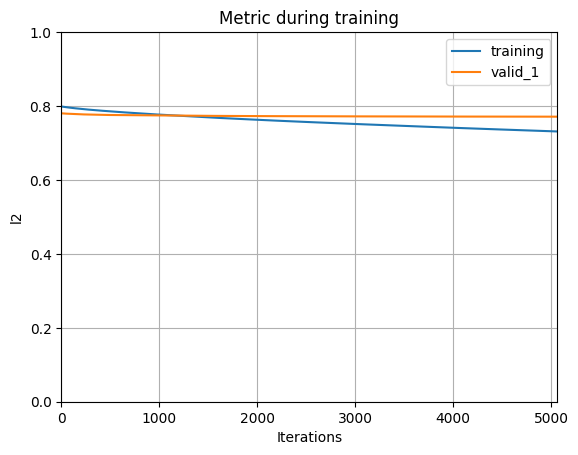

[50]	training's l2: 0.792922	valid_1's l2: 0.795581
[100]	training's l2: 0.791284	valid_1's l2: 0.794781
[150]	training's l2: 0.789795	valid_1's l2: 0.794087
[200]	training's l2: 0.788424	valid_1's l2: 0.793528
[250]	training's l2: 0.787155	valid_1's l2: 0.79307
[300]	training's l2: 0.785985	valid_1's l2: 0.792688
[350]	training's l2: 0.784866	valid_1's l2: 0.792309
[400]	training's l2: 0.783799	valid_1's l2: 0.791998
[450]	training's l2: 0.782775	valid_1's l2: 0.791708
[500]	training's l2: 0.781756	valid_1's l2: 0.791458
[550]	training's l2: 0.780787	valid_1's l2: 0.791256
[600]	training's l2: 0.779855	valid_1's l2: 0.791053
[650]	training's l2: 0.778925	valid_1's l2: 0.790835
[700]	training's l2: 0.77804	valid_1's l2: 0.790663
[750]	training's l2: 0.777182	valid_1's l2: 0.790488
[800]	training's l2: 0.776344	valid_1's l2: 0.790308
[850]	training's l2: 0.775521	valid_1's l2: 0.790184
[900]	training's l2: 0.774691	valid_1's l2: 0.790079
[950]	training's l2: 0.773888	valid_1's l2: 0.789

<Figure size 640x480 with 0 Axes>

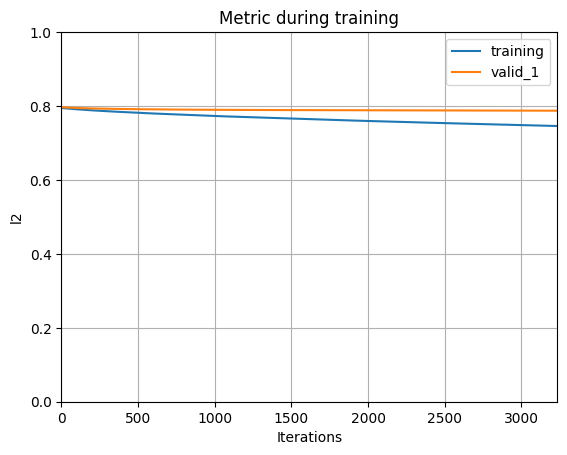

R2 score is: 0.012449033183687064
Weighted R2 score is: 0.012766034293170803


In [28]:
lgb_train(sample_train_df, sample_y_sr)